In [1]:
import numpy as np
from numpy.linalg import norm, svd
import matplotlib.pyplot as pl
import itertools as it
import functools as ft

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import sys
sys.path.append('/Users/dsuess/Code/Pythonlibs/')
# see https://github.com/dseuss/pythonlibs
from tools.helpers import Progress

In [2]:
mydot = ft.partial(np.tensordot, axes=(-1, 0))

def vec(A):
    newshape = A.shape[:-2]
    newshape = newshape + (A.shape[-2] * A.shape[-1],)
    return A.reshape(newshape)

def unvec(A):
    """Use with care and only if you know A is supposed to be
    square
    """
    dim = int(np.sqrt(A.shape[-1]))
    assert dim**2 == A.shape[-1], \
        "Cannot unvec array with shape {}" \
        .format(A.shape[-1])
        
    newshape = A.shape[:-1] + (dim, dim)
    return A.reshape(newshape)

A = np.random.randn(10, 5, 67, 2, 4, 4)
assert np.all(unvec(vec(A)) == A)

In [3]:
def random_lowrank_hmatrix(dim, rank, rgen=np.random):
    A = rgen.randn(dim, rank)
    return A @ A.T

def random_lowrank_matrix(dim, rank, rgen=np.random):
    A, B = rgen.randn(2, dim, rank)
    return A @ B.T
    
def sensingmats_gaussian(m, dim, rgen=np.random):
    return rgen.randn(m, dim, dim) / np.sqrt(m)

def compression(mat, rank):
    """PU, PV ... projectors on left/right eigenspaces"""
    U_full, s, Vstar_full = svd(mat)
    U = U_full[:, :rank]
    V = Vstar_full.T.conj()[:, :rank]
    PU = U @ U.T.conj()
    PV = V @ V.T.conj()
    return U @ np.diag(s[:rank]) @ V.conj().T, (PU, PV)

In [4]:
def get_stepsize(A, g, projectors, restriction):
    PU, PV = projectors
    if restriction == 'const':
        return 5000
    elif restriction == 'col':
        g = PU @ g
    elif restriction == 'row':
        g = g @ PV
    elif restriction == 'rowcol':
        g = PU @ g @ PV
    else:
        raise ValueError("{} if not a valid restriction format"
                         .format(restriction))
    return norm(g)**2 / norm(vec(A) @ vec(g))**2


def aIHT(X, m, r, rgen=np.random, restriction='rowcol', X_init=None,
         sensingmat=None):
    dim = X.shape[0]
    A = sensingmats_gaussian(m, dim) if sensingmat is None else sensingmat
    # normalize for use with constant stepsize
    A /= np.linalg.norm(A) 
        
    m = A.shape[0]
    y = vec(A.conj()) @ vec(X)
    
    X_hat = np.zeros(X.shape) if X_init is None else X_init
    _, projectors = compression(mydot(y, A), r)
    global stepsize
    
    while True:
        g = mydot(y - (vec(A) @ vec(X_hat)), A)
        mu = get_stepsize(A, g, projectors, restriction)
        stepsize.append(mu)
        X_hat, projectors = compression(X_hat + mu * g, r)
        yield X_hat

In [5]:
from csalgs.lowrank.iht import iht_estimator

In [13]:
%autoreload 2

 99% (198 of 200) |###################### | Elapsed Time: 0:00:00 ETA:  0:00:00

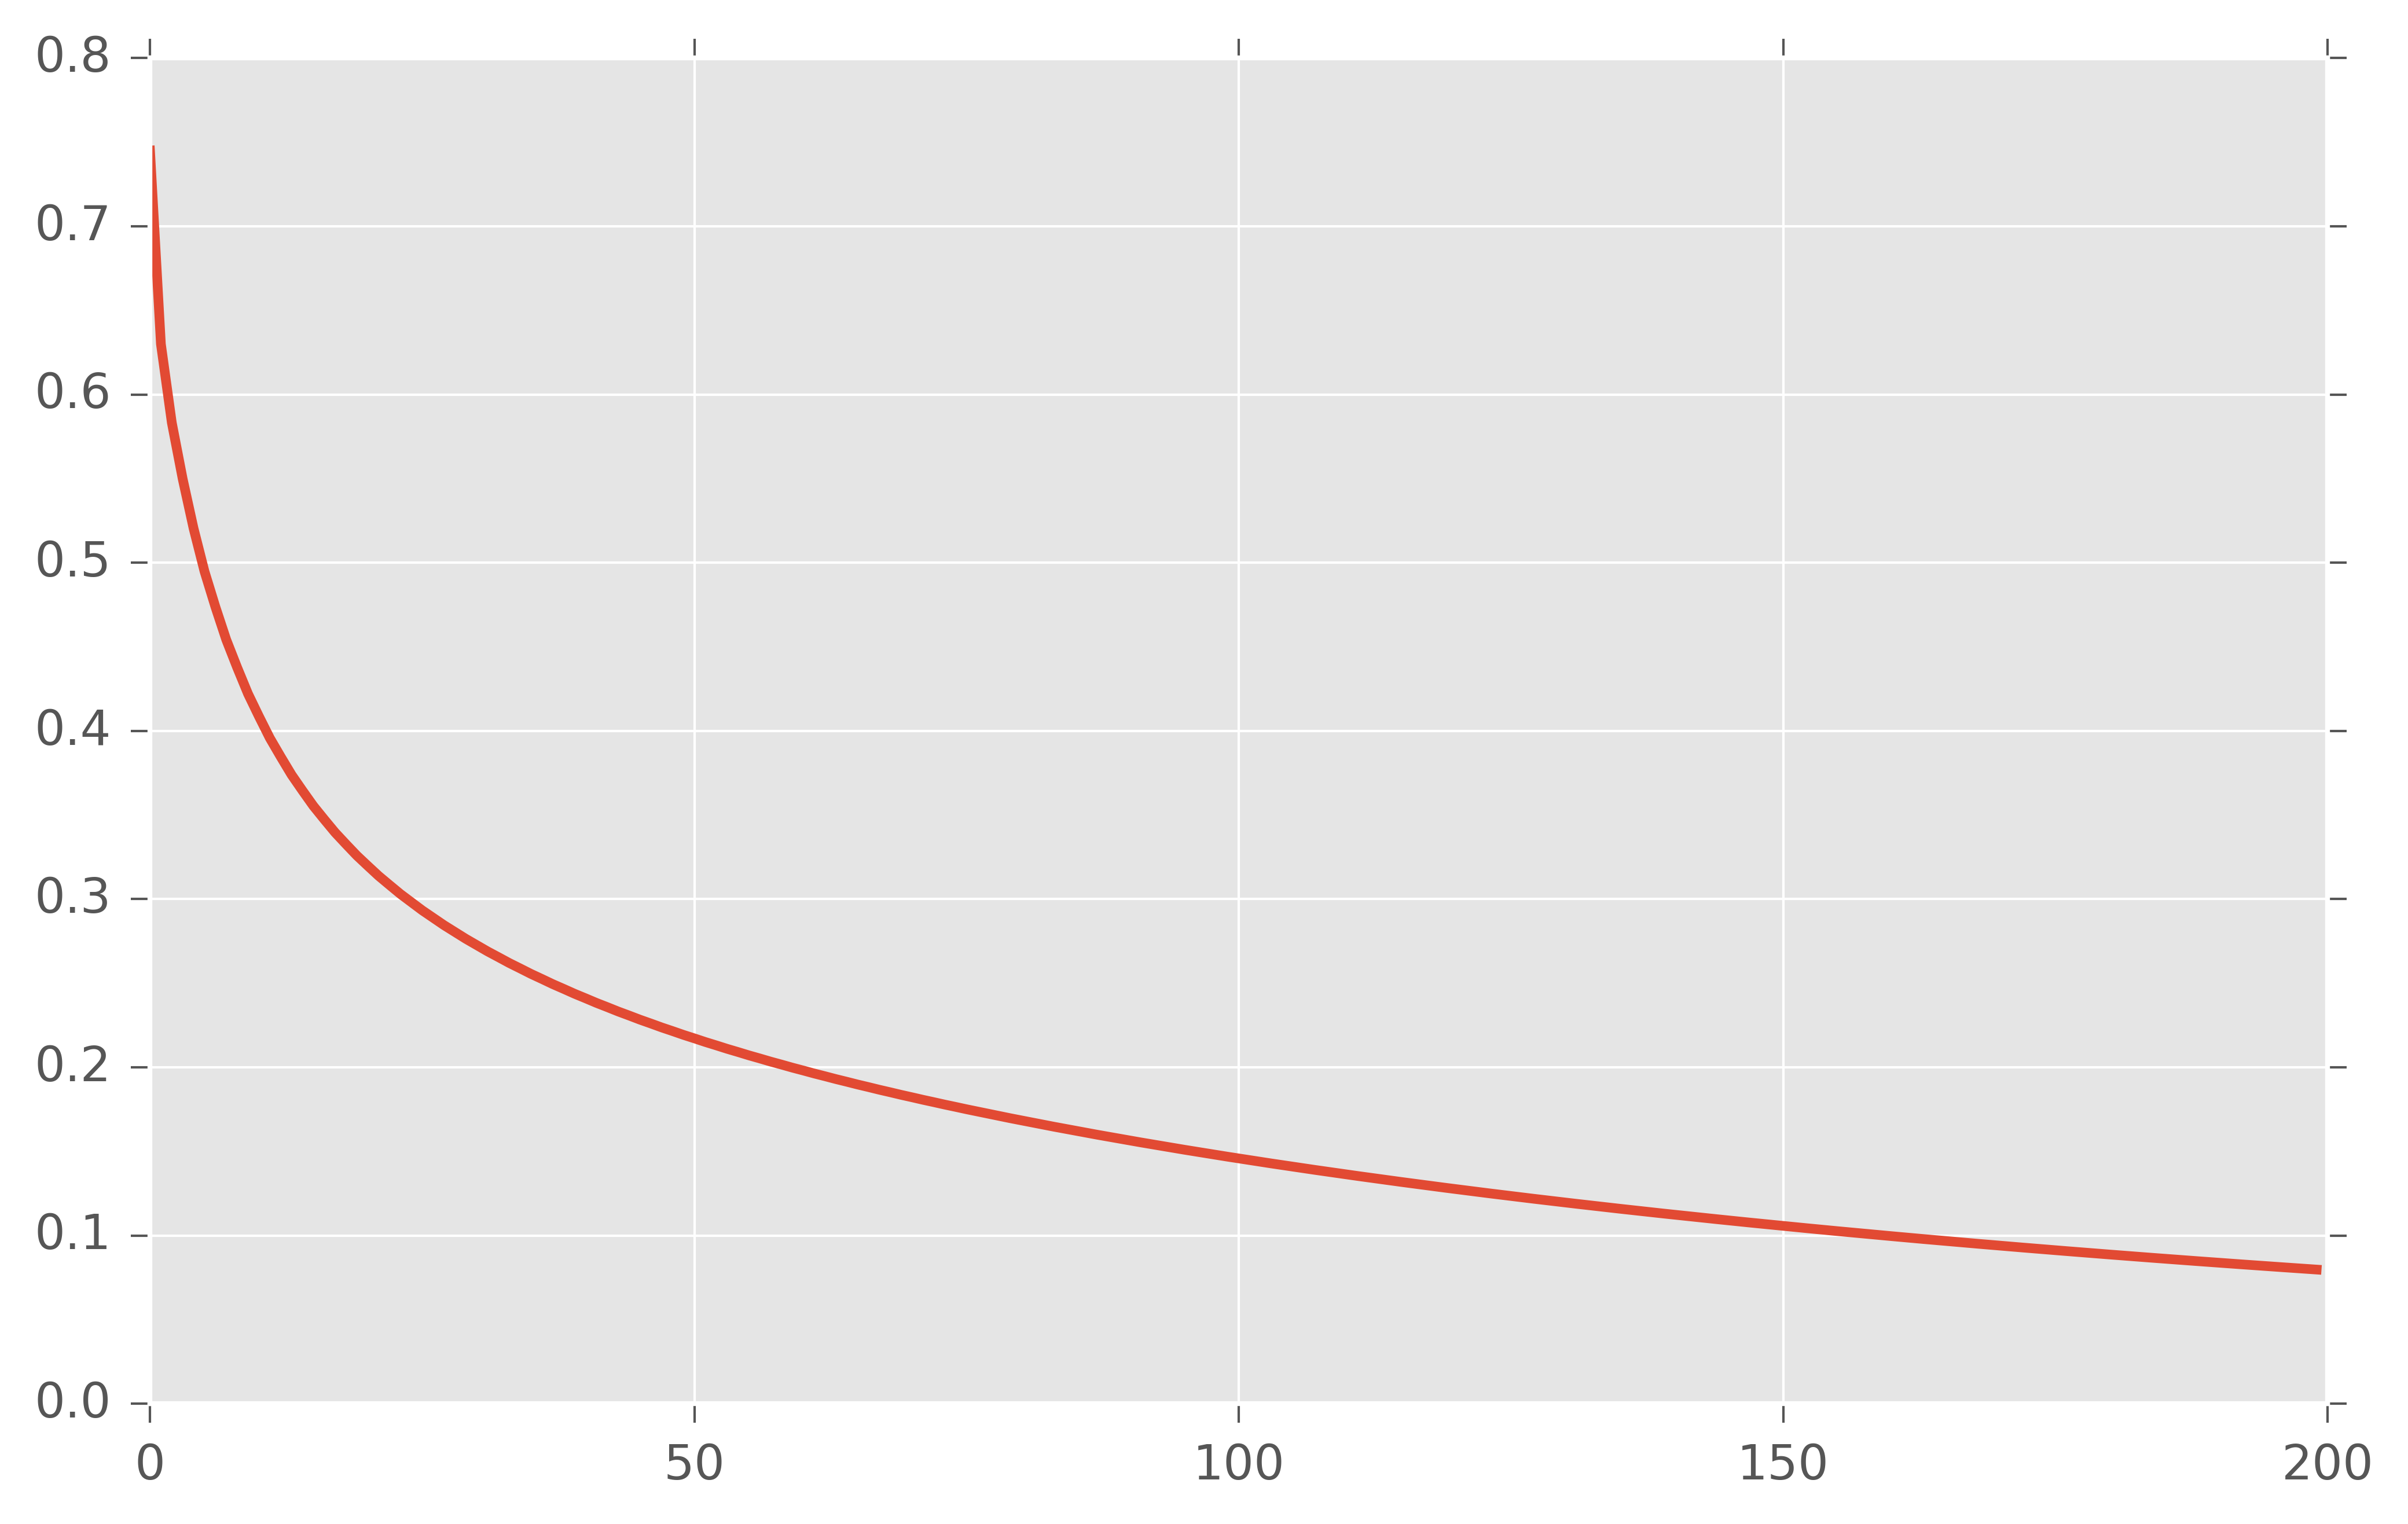

In [14]:
stepsize = []
DIM = 30
RANK = 5
MEASUREMENTS = 600
ITSTEPS = 200
X = random_lowrank_matrix(DIM, RANK)
X /= np.linalg.norm(X)
A = sensingmats_gaussian(MEASUREMENTS, DIM)
y = vec(A) @ vec(X)

solution = it.islice(iht_estimator(A, y, 2 * RANK), ITSTEPS)
errors = [norm(X - X_hat) for X_hat in Progress(solution, max_value=ITSTEPS)]
pl.plot(errors)

In [ ]:
stepsize = []
DIM = 30
RANK = 5
MEASUREMENTS = 600
ITSTEPS = 200
X = random_lowrank_matrix(DIM, RANK)
X /= np.linalg.norm(X)
 
for mode in ('row', 'col', 'rowcol'):
#for mode in ('const',):
    solution = it.islice(aIHT(X, MEASUREMENTS, 2 * RANK, restriction=mode),
                         ITSTEPS)
    errors = [norm(X - X_hat) for X_hat in Progress(solution, max_value=ITSTEPS)]
    pl.plot(errors, label=mode)
    print("{}: {}".format(mode, errors[-1]))

pl.ylim((0, 2* errors[0]))
pl.legend()

100% (200 of 200) |#####################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
 20% ( 40 of 200) |####################                                                                                 | Elapsed Time: 0:00:00 ETA:  0:00:00

row: 0.0802402772647838


100% (200 of 200) |#####################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
 15% ( 31 of 200) |###############                                                                                      | Elapsed Time: 0:00:00 ETA:  0:00:00

col: 0.07380347947206202


 72% (144 of 200) |########################################################################                             | Elapsed Time: 0:00:00 ETA:  0:00:00

rowcol: 0.011720249611156582


100% (200 of 200) |#####################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00


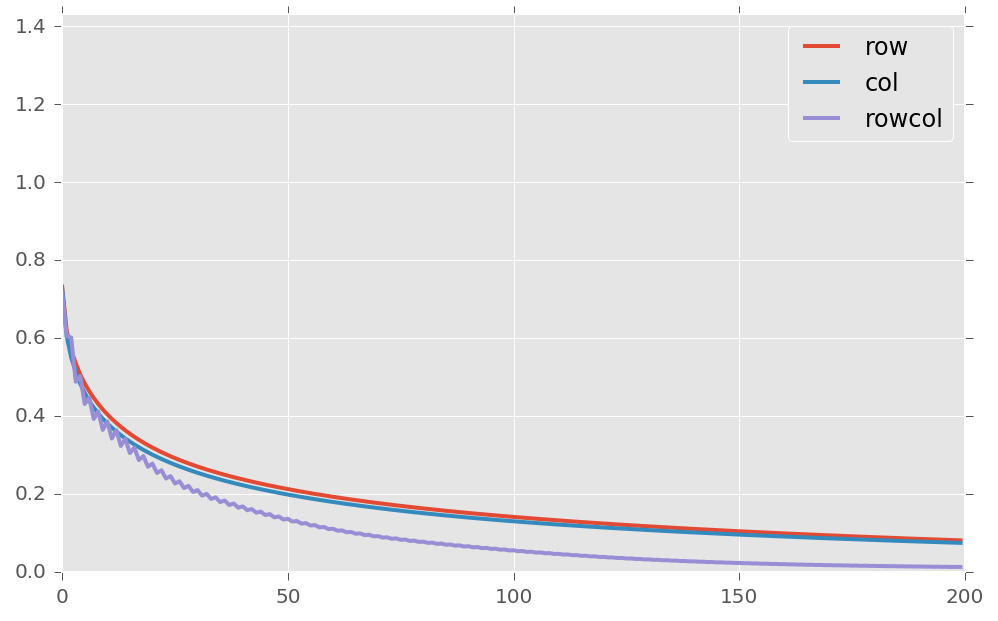

In [5]:
stepsize = []
DIM = 30
RANK = 5
MEASUREMENTS = 600
ITSTEPS = 200
X = random_lowrank_matrix(DIM, RANK)
X /= np.linalg.norm(X)
 
for mode in ('row', 'col', 'rowcol'):
#for mode in ('const',):
    solution = it.islice(aIHT(X, MEASUREMENTS, 2 * RANK, restriction=mode),
                         ITSTEPS)
    errors = [norm(X - X_hat) for X_hat in Progress(solution, max_value=ITSTEPS)]
    pl.plot(errors, label=mode)
    print("{}: {}".format(mode, errors[-1]))

pl.ylim((0, 2* errors[0]))
pl.legend()

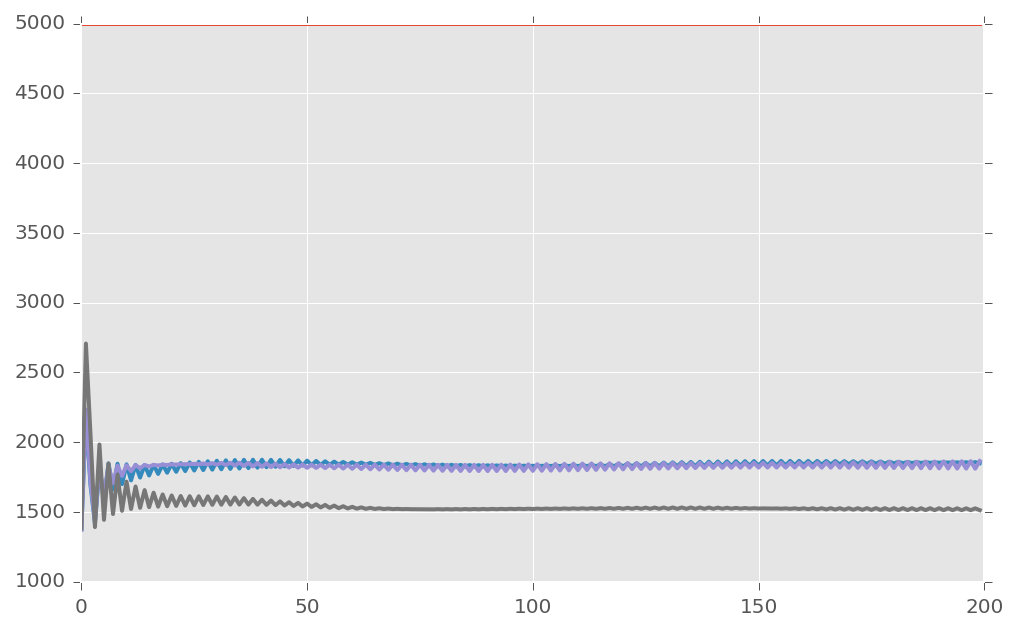

In [68]:
stepsize = np.reshape(stepsize, (4, -1))
for s in stepsize:
    pl.plot(s)

100% (100 of 100) |#####################################################################################################| Elapsed Time: 0:00:48 Time: 0:00:48


row: 0.029444938615254733


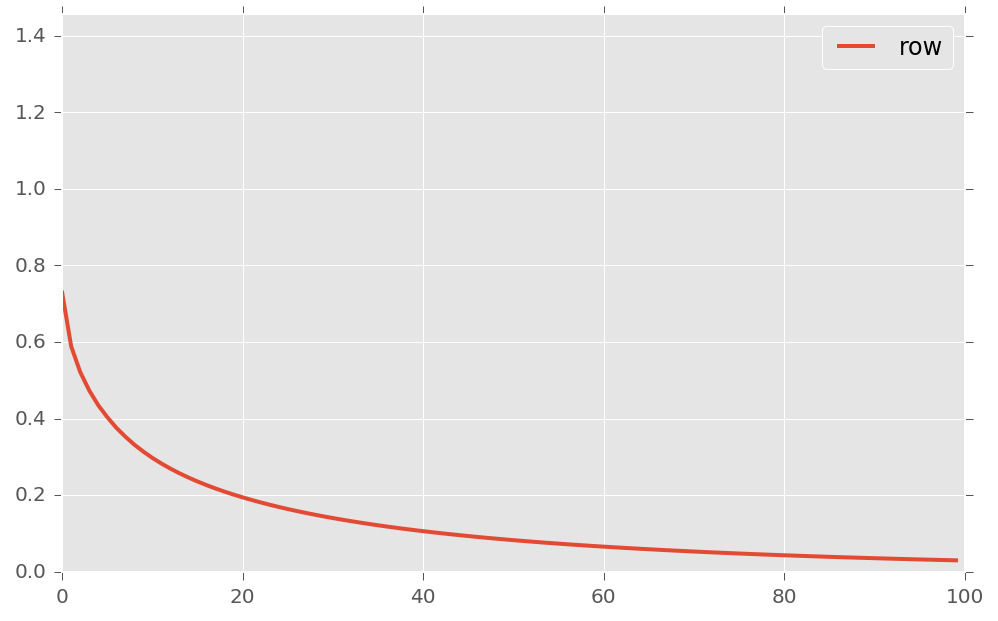

In [16]:
DIM = 200
RANK = 5
ITSTEPS = 100
MEASUREMENTS = int((2*DIM - RANK) * RANK * 3)

X = random_lowrank_matrix(DIM, RANK)
X /= np.linalg.norm(X)
mode = 'row'
#for mode in ('row', 'col', 'rowcol'):
for _ in range(1):
    solution = it.islice(aIHT(X, MEASUREMENTS, 2 * RANK, restriction=mode),
                         ITSTEPS)
    errors = [norm(X - X_hat) for X_hat in Progress(solution, max_value=ITSTEPS)]
    pl.plot(errors, label=mode)
    print("{}: {}".format(mode, errors[-1]))

pl.ylim((0, 2* errors[0]))
pl.legend()